# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib  # please use matplotlib 3.5.1
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


Bad key text.latex.preview in file /Users/ilana/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/ilana/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/ilana/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the de

In [2]:
# Function for ploting the decision boundaries of a model
# Graders: this was updated to allow axes for graphing
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01, ax=None):
    
    if ax is None:
        ax = plt.gca()
    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')
    #plt.sca(ax)

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
#### Your code here ####
def histogram_visualization(data_0, data_1, bins, alpha, title):
    plt.hist(data_0, bins=bins, alpha=alpha, label='y=0')
    plt.hist(data_1, bins=bins, alpha=alpha, label='y=1')
    plt.legend()
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    
def scatter_visualization(data_0, data_1, title):
    plt.scatter(data_0[:, 0], data_0[:, 1], label='y=0')
    plt.scatter(data_1[:, 0], data_1[:, 1], label='y=1')
    plt.legend()
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.show()

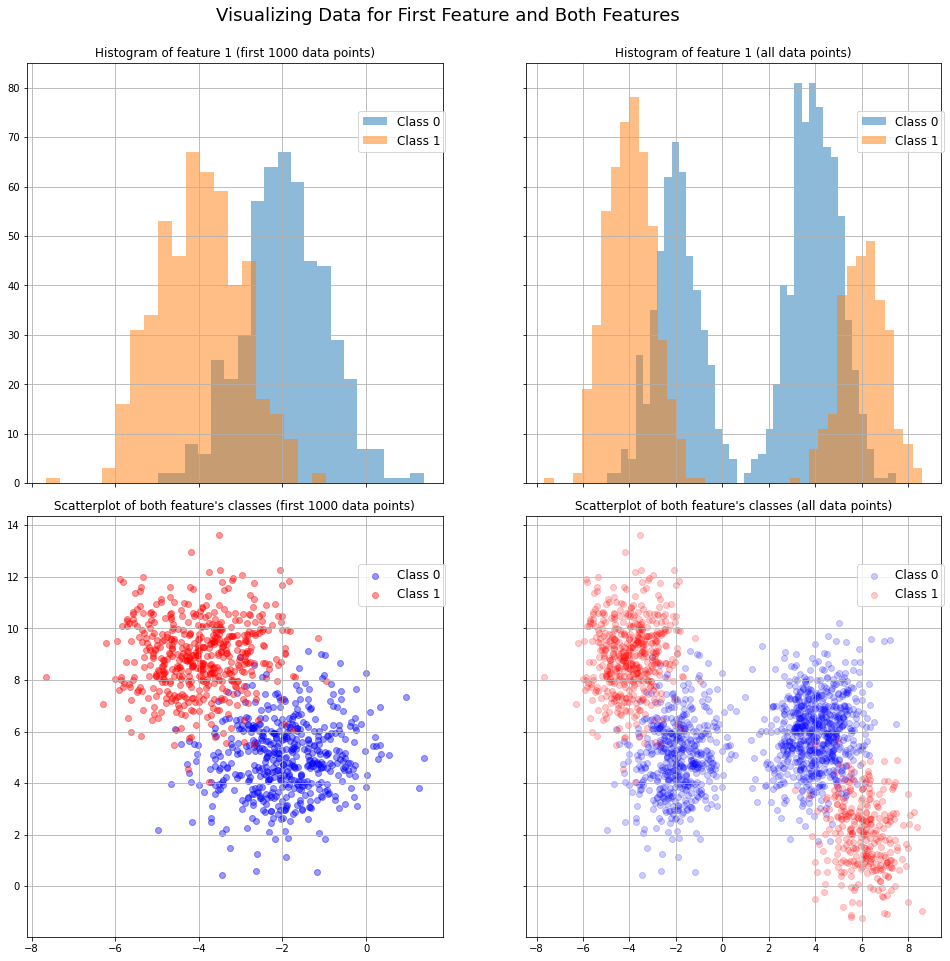

In [5]:
fig = plt.figure(figsize=(14, 14)) 
fig.suptitle('Visualizing Data for First Feature and Both Features', fontsize=18)    
gs = fig.add_gridspec(2, 2, hspace=0.5, wspace=0.5, bottom=0.5,
                       left=0.45, right=0.5)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')


y_cut = y_training[:1000]
x_cut = X_training[:1000]
split_df = training_set[:1000]

for i_class in np.unique(y_training):

    ax1.hist(x_cut[:,0][y_cut == i_class], bins=20, alpha = 0.5, label='Class '+str(i_class))

    ax2.hist(X_training[:,0][y_training == i_class], bins=40, alpha = 0.5, label='Class '+str(i_class))
                            
    ax3.scatter(data=split_df[split_df['y']==i_class],x= 'x1',y= 'x2', c=['blue','red'][i_class],label = 'Class ' + str(i_class), alpha = .4)

    ax4.scatter(data=training_set[training_set['y'] == i_class], x='x1', y='x2', alpha=0.2, label='Class '+str(i_class), c=['blue','red'][i_class])

ax1.legend(loc=1, bbox_to_anchor=(1.02, .9), prop={'size': 12})
ax2.legend(loc=1, bbox_to_anchor=(1.02, .9), prop={'size': 12})
ax3.legend(loc=1, bbox_to_anchor=(1.02, .9), prop={'size': 12})
ax4.legend(loc=1, bbox_to_anchor=(1.02, .9), prop={'size': 12})

ax1.grid(True)
ax1.plot()
ax2.grid(True)
ax2.plot()
ax3.grid(True)
ax3.plot()
ax4.grid(True)
ax4.plot()
    
ax1.set_title("Histogram of feature 1 (first 1000 data points)")
ax2.set_title('Histogram of feature 1 (all data points)')
ax3.set_title("Scatterplot of both feature's classes (first 1000 data points)")
ax4.set_title("Scatterplot of both feature's classes (all data points)")

# It is 2022 and matplotlib has a title bug? We fix it with tightlayout and some headspace definitions
gs.tight_layout(fig, rect=[0, 0.03, 1, .98]) 
plt.show()

## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [6]:
class LogisticRegressionGD:
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

        self.theta = None
        self.J_history = []

    def fit(self, X, y, verbose=False):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

        # random initialization of theta:
        
        if self.random_state is None:
            rnd = np.random.default_rng()
        else:
            rnd = np.random.default_rng(random_state)
        self.theta = rnd.random(X.shape[1])   
        
        out = np.empty(X.shape[0]) # allocate array for in-place arithmetics, this should be faster
        
        # re-initialize history (in case someone call 'fit()' twice)
        self.J_history = [self.cost(X, y)]
        for i in range(self.n_iter):        
            self.theta = self.theta - self.eta * np.sum(X*np.subtract(self.h(X,out), y, out=out).reshape(-1,1), axis=0)/X.shape[0]
            self.J_history.append(self.cost(X, y)) # append new value of the cost after the gradient step
            if abs(self.J_history[-2] - self.J_history[-1]) < self.eps:
                break
            if verbose and (i+1)%1000==0: print(i+1, " : ", self.theta, f" [{self.J_history[-1]:.3f}]", sep="")
                
            

    def predict(self, X):
        """Return the predicted class label"""
        X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        return np.where(self.h(X) > 0.5, 1, 0)

    def cost(self, X, y, out=None):
        out1 = self.h(X, out) 
        out2 = 1-out1
        np.log(out1,out=out1)
        np.log(out2,out=out2)
        np.multiply(y,out1,out=out1)
        np.multiply(1-y,out2,out=out2)
        np.subtract(np.negative(out1,out=out1),out2,out=out1)
        return out1.sum()/X.shape[0]

    def gradient(self, X, y):
        return np.sum(X*(self.h(X).reshape(-1,1) - y.reshape(-1,1))/X.shape[0],axis=0)
        
    
    def h(self, X, out=None):
        """Returns h(X) as a 1D array (row). Can use pre-allocated array for 
            all intrermediate calculations when provided"""
        out = np.dot(X,self.theta.T, out=out)
        np.exp(-out, out=out)
        np.add(1,out,out=out)
        return np.divide(1 , out, out=out)

1000 : [0.48745308 0.12702171 0.22020936] [0.860]
2000 : [0.47286719 0.14534879 0.16125724] [0.778]
3000 : [0.46143579 0.15338771 0.12567249] [0.748]
4000 : [0.45208748 0.15460374 0.1058442 ] [0.738]
5000 : [0.44390546 0.1520393  0.09491408] [0.734]
6000 : [0.43632802 0.14756784 0.0886069 ] [0.732]
7000 : [0.42905471 0.14219152 0.08462025] [0.730]
8000 : [0.4219338  0.13641577 0.0817876 ] [0.728]
9000 : [0.41489056 0.13048881 0.07953352] [0.726]
10000 : [0.40788865 0.12453081 0.07757755] [0.725]


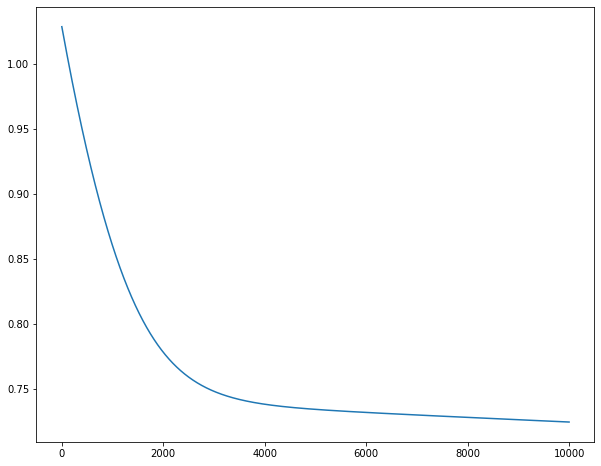

In [7]:
# Pure test:
LR=LogisticRegressionGD()

LR.fit(x_cut,y_cut, verbose=True)

plt.plot(LR.J_history);

1000 : [-3.89667767 -0.57687225  0.36056652] [0.295]
2000 : [-5.87189449 -0.76392543  0.55515298] [0.214]
3000 : [-7.16394515 -0.89308579  0.68059352] [0.180]
4000 : [-8.13066733 -0.99238517  0.77370273] [0.161]
5000 : [-8.90593144 -1.0734066   0.8479879 ] [0.148]
6000 : [-9.55439243 -1.14201095  0.9098989 ] [0.140]
7000 : [-10.11231262  -1.20158456   0.96302371] [0.133]
8000 : [-10.60213024  -1.25426843   1.00956846] [0.128]
9000 : [-11.03873081  -1.30150683   1.05098928] [0.124]
10000 : [-11.43251613  -1.34432272   1.08829941] [0.121]
11000 : [-11.79105367  -1.38346873   1.12223342] [0.119]
12000 : [-12.12002883  -1.41951575   1.15334153] [0.116]
13000 : [-12.42382669  -1.45290774   1.18204703] [0.115]
14000 : [-12.70590415  -1.48399727   1.20868286] [0.113]
15000 : [-12.96903722  -1.51306927   1.23351584] [0.112]
16000 : [-13.21549067  -1.54035753   1.2567633 ] [0.110]
17000 : [-13.44713768  -1.56605644   1.27860469] [0.109]


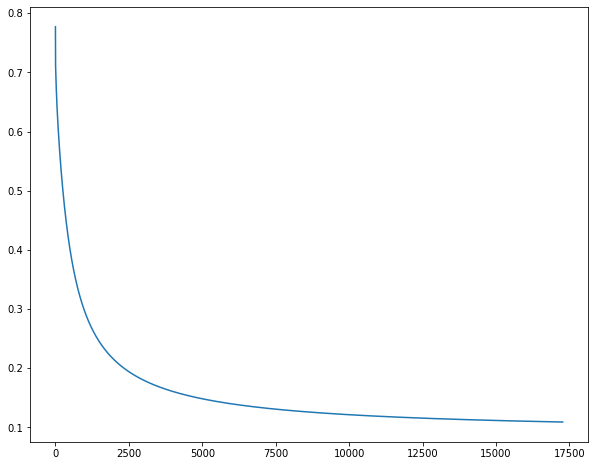

In [8]:
# Test
LR=LogisticRegressionGD(eta=0.05, eps=0.000001, n_iter=100000)

LR.fit(x_cut,y_cut, verbose=True)

plt.plot(LR.J_history)

Note that the code above initializes n_iter to 100,000). We can change the parameters, rerun that cell,  and see how the model converges. Or not. Repeat a few times. The verbose diagnostics prints the cost at the end of each line. We can see that at eta=0.05 and n_iter 10000 by the time you run out of iterations you get to the error around 0.121. You can in fact get to ~0.109 with the parameters shown above (more iterations!). But if you set eta to 0.0005 or some other even smaller value - you will end up with MUCH larger cost at the end, because there will be not enough iterations to converge with such a small learning rate. You may also need to further decrease eps, because with such small learning rate each gradient step becomes so small that the cost almost does not change and the code will stop on the 'change in cost < eps' condition even before it reaches n_iter. But that will *not* be a stable, convergent value. Just a premature bail out. Just set eps to some really small number and run with some ridiculous number of iterations, like 100,000 or even a 1,000,000 - and you will see that only *then* the model just keeps creeping down in cost even at very small values of eta. But it never reaches good accuracy with small eta while using default n_iter=10000. It just cannot converge so fast

## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [9]:
def compute_accuracy(classifier, testset, y=None):
    """If y is None (default), then it is assumed that outcomes are provided in the last 
       column of the testset. Otherwise, the outcomes are taken from y while 'testset' is
       assumed to hold predictor variables *only*"""
    correct = 0
    if y is None:
        predictions = classifier.predict(testset[:, :-1])
        y = testset[:,-1]
    else:
        predictions = classifier.predict(testset)        
        
    correct = np.sum(predictions==y)
    
    return correct / len(testset)

For accuracy, it seems that in cross-validation it is better to look at the average accuracy, not at the best one we were lucky enough to get because one of the random folds just happened by chance to be better than the others.



In [10]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

training_set_values = training_set.values.copy()
np.random.shuffle(training_set_values)
fold_list = np.vsplit(training_set_values, 5)

accuracies = {}

for i, dataset in enumerate(fold_list):
    validation_set = dataset.copy()
    fold_list_copy = fold_list.copy()
    fold_list_copy.pop(i)
    train_set = np.vstack(fold_list_copy)
    X_train, y_train = train_set[:, :-1], train_set[:, -1]

    for eta in etas:
        for eps in epss:
            lr = LogisticRegressionGD(eta=eta, eps=eps)
            lr.fit(X_train, y_train)
            accuracy = compute_accuracy(lr, validation_set)
            
            # because no default dict
            if (eta, eps) in accuracies:
                accuracies[(eta, eps)].append(accuracy)
            else:
                accuracies[(eta, eps)] = [accuracy]

# compute *average* accuracy for each combination of the parameters
for (eta, eps) in accuracies:
    accuracies[(eta,eps)] = np.mean(accuracies[(eta,eps)])
    print(f"Eta={eta} eps={eps}: {accuracies[(eta,eps)]*100:0.2f}%")

best_eta, best_eps = max(accuracies, key=accuracies.get)
print(f'Best eta: {best_eta}, Best eps: {best_eps}, Max Accuracy: {accuracies.get((best_eta, best_eps))}')

Eta=0.05 eps=0.01: 52.90%
Eta=0.05 eps=0.001: 55.65%
Eta=0.05 eps=0.0001: 57.95%
Eta=0.05 eps=1e-05: 64.80%
Eta=0.05 eps=1e-06: 78.20%
Eta=0.005 eps=0.01: 31.70%
Eta=0.005 eps=0.001: 58.40%
Eta=0.005 eps=0.0001: 54.15%
Eta=0.005 eps=1e-05: 58.50%
Eta=0.005 eps=1e-06: 66.55%
Eta=0.0005 eps=0.01: 40.65%
Eta=0.0005 eps=0.001: 30.75%
Eta=0.0005 eps=0.0001: 54.95%
Eta=0.0005 eps=1e-05: 54.90%
Eta=0.0005 eps=1e-06: 60.75%
Eta=5e-05 eps=0.01: 36.30%
Eta=5e-05 eps=0.001: 36.90%
Eta=5e-05 eps=0.0001: 28.85%
Eta=5e-05 eps=1e-05: 41.70%
Eta=5e-05 eps=1e-06: 53.80%
Eta=5e-06 eps=0.01: 39.05%
Eta=5e-06 eps=0.001: 39.85%
Eta=5e-06 eps=0.0001: 38.70%
Eta=5e-06 eps=1e-05: 36.80%
Eta=5e-06 eps=1e-06: 39.65%
Best eta: 0.05, Best eps: 1e-06, Max Accuracy: 0.782


## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [11]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp(-np.square((data - mu)/sigma) / 2 ) / (np.sqrt(2 * np.pi)*sigma)

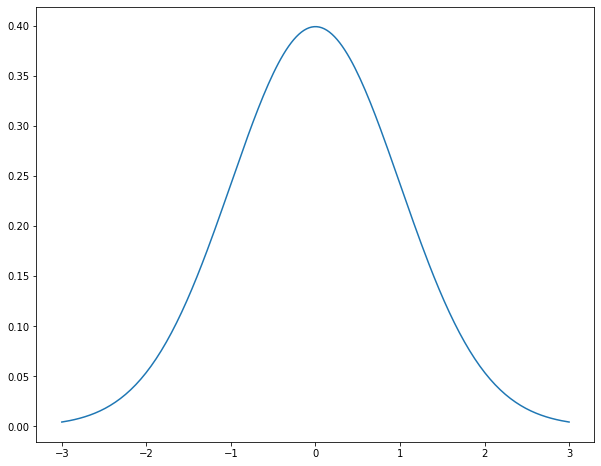

In [12]:
x=np.linspace(-3,3,200)
plt.plot(x,norm_pdf(x,0,1));

## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [13]:
class EM:
    """
    Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM process
    eps: float
      minimal change in the cost to declare convergence
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.means = []
        self.stds = []
        self.weights = []
        self.response = {}
        self.J_history = []
        np.random.seed(42)

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.means = []
        self.stds = []
        self.response = {}
        df = np.array_split(data, self.k)
        for d in df:
            self.means.append(np.mean(d))
            self.stds.append(np.std(d))

        # Draw samples from the Dirichlet distribution.
        self.weights = np.random.dirichlet(np.arange(1, self.k + 1))

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        val = 0
        for i in range(self.k):
            val += self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])

        for i in range(self.k):
            counter = self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])
            self.response[i] = counter / val

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        for i in range(self.k):
            self.weights[i] = np.sum(self.response[i]) / len(data)
            self.means[i] = np.sum(self.response[i] * data) / (self.weights[i] * len(data))
            self.stds[i] = np.sqrt(np.sum(self.response[i] * np.square(data - self.means[i])) / (self.weights[i] * len(data)))

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)

        for i in range(self.n_iter):
            self.expectation(data)
            self.maximization(data)
            cost = self.compute_cost(data)
            self.J_history.append(cost)
            
            if len(self.J_history) > 1:
                if self.J_history[-2] - self.J_history[-1] < self.eps:
                    break

    def get_dist_params(self):
        return np.array(self.means), np.array(self.stds), self.weights

    def compute_cost(self, data):
        cost = 0
        for i in range(self.k):
            cost += np.sum(-np.log(self.weights[i] * norm_pdf(data, self.means[i], self.stds[i])))
        return cost
    
    def get_final_liklyhood(self,data):
        return np.sum(np.dot(norm_pdf(data,self.mu,self.sigma), self.weights))

## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [14]:
class NaiveBayesGaussian:
    """
    Naive Bayes Classifier using Gaussian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    """

    def __init__(self, k=1):
        self.k = k
        self.params = {}
        self.em = EM(self.k)

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        features = np.arange(X.shape[1])
        dataset = np.hstack((X, y.reshape(-1, 1)))
        classes, count = np.unique(y, return_counts=True)

        for val in classes:
            self.params[val] = {}
            by_class = dataset[dataset[:, -1] == val]
            prior = len(by_class) / len(dataset)
            self.params[val]['prior'] = prior

            means, stds, weights = [], [], []
            for feature in features:
                self.em.fit(by_class[:, feature])
                mean, std, weight = self.em.get_dist_params()
                means.append(mean)
                stds.append(std)
                weights.append(weight)

            self.params[val]['means'] = means
            self.params[val]['stds'] = stds
            self.params[val]['weights'] = weights

    def predict(self, X):
        """Return the predicted class label"""
        post = {}
        pred = []
        classes = list(self.params.keys())
        features = np.arange(X.shape[1])

        for val in classes:
            l = 1
            for feature in features:
                data = X[:, feature]
                k_probs = np.zeros((self.k, len(data)))
                for i in range(self.k):
                    mean = self.params[val]['means'][feature][i]
                    std = self.params[val]['stds'][feature][i]
                    weight = self.params[val]['weights'][feature][i]
                    k_probs[i] = weight*norm_pdf(data, mean, std)
                l *= np.sum(k_probs, axis=0)
            posterior = l * self.params[val]['prior']
            post[val] = posterior
        for i in range(len(X)):
            if post[0][i] > post[1][i]:
                pred.append(0)
            else:
                pred.append(1)

        return np.array(pred)

## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

### First 1000 training points and first 500 test points

In [15]:
train_vals = training_set.head(1000).values
x_train = train_vals[:, :-1]
y_train = train_vals[:, -1]

test_vals = test_set.head(500).values
x_test = test_vals[:, :-1]
y_test = test_vals[:, -1]

lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr.fit(x_train, y_train)
nb = NaiveBayesGaussian(k=1)
nb.fit(x_train, y_train)

# compute accuracies
lr_train_accuracy = compute_accuracy(lr, train_vals)
lr_test_accuracy = compute_accuracy(lr, test_vals)
nb_train_accuracy = compute_accuracy(nb, train_vals)
nb_test_accuracy = compute_accuracy(nb, test_vals)

print(f'Logistic Regression (1000 points): Train Accuracy = {lr_train_accuracy}')
print(f'Logistic Regression (500 points): Test Accuracy = {lr_test_accuracy}')
print(f'Naive Bayes (1000 points): Train Accuracy = {nb_train_accuracy}')
print(f'Naive Bayes (500 points): Test Accuracy = {nb_test_accuracy}')


Logistic Regression (1000 points): Train Accuracy = 0.965
Logistic Regression (500 points): Test Accuracy = 0.938
Naive Bayes (1000 points): Train Accuracy = 0.966
Naive Bayes (500 points): Test Accuracy = 0.942


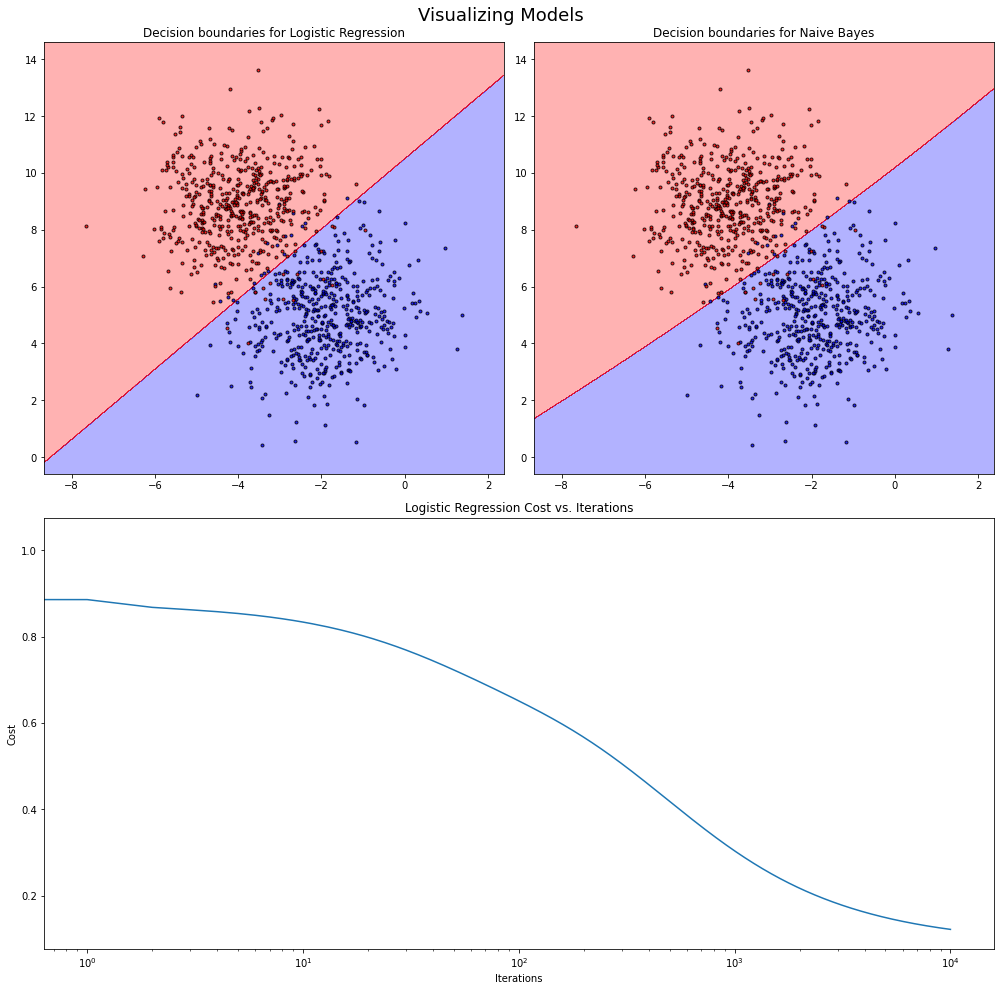

In [16]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(14, 14)) 
fig.suptitle('Visualizing Models', fontsize=18)    

plot_decision_regions(x_train, y_train, lr, ax=axs[0,0])
plot_decision_regions(x_train, y_train, nb, ax=axs[0,1])


gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1,:]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])

axbig.plot(lr.J_history)
axbig.set_xscale('log')
axbig.set_xlabel('Iterations')
axbig.set_ylabel('Cost')


axs[0,0].set_title("Decision boundaries for Logistic Regression")
axs[0,1].set_title('Decision boundaries for Naive Bayes')
axbig.set_title("Logistic Regression Cost vs. Iterations")

fig.tight_layout()

plt.show();

For our subsetted data, we have two classes and we can observe visualy that there is a separation between them. Therefor, when applying logistic regression and naive bayes, both will yield rather good results and perform well since the two classes were both largely independent. 

We can see however, that the cost struggles to converge completely quickly.

### All the training and the test set points

In [17]:
train_vals = training_set.values
x_train = train_vals[:, :-1]
y_train = train_vals[:, -1]
test_vals = test_set.values
x_test = test_vals[:, :-1]
y_test = test_vals[:, -1]

lr = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr.fit(x_train, y_train)

nb1 = NaiveBayesGaussian(k=1)
nb1.fit(x_train, y_train)

nb2 = NaiveBayesGaussian(k=2)
nb2.fit(x_train, y_train)

nb3 = NaiveBayesGaussian(k=3)
nb3.fit(x_train, y_train)

nb4 = NaiveBayesGaussian(k=4)
nb4.fit(x_train, y_train)

lr_train_accuracy = compute_accuracy(lr, train_vals)
lr_test_accuracy = compute_accuracy(lr, test_vals)
nb1_train_accuracy = compute_accuracy(nb1, train_vals)
nb1_test_accuracy = compute_accuracy(nb1, test_vals)

nb2_train_accuracy = compute_accuracy(nb2, train_vals)
nb2_test_accuracy = compute_accuracy(nb2, test_vals)

nb3_train_accuracy = compute_accuracy(nb3, train_vals)
nb3_test_accuracy = compute_accuracy(nb3, test_vals)

nb4_train_accuracy = compute_accuracy(nb4, train_vals)
nb4_test_accuracy = compute_accuracy(nb4, test_vals)

print(f'Logistic Regression: Train Accuracy = {lr_train_accuracy}')
print(f'Logistic Regression: Test Accuracy = {lr_test_accuracy}')
print(f'Naive Bayes (k=1): Train Accuracy = {nb1_train_accuracy}')
print(f'Naive Bayes (k=1): Test Accuracy = {nb1_test_accuracy}')
print(f'Naive Bayes (k=2): Train Accuracy = {nb2_train_accuracy}')
print(f'Naive Bayes (k=2): Test Accuracy = {nb2_test_accuracy}')
print(f'Naive Bayes (k=3): Train Accuracy = {nb3_train_accuracy}')
print(f'Naive Bayes (k=3): Test Accuracy = {nb3_test_accuracy}')
print(f'Naive Bayes (k=4): Train Accuracy = {nb4_train_accuracy}')
print(f'Naive Bayes (k=4): Test Accuracy = {nb4_test_accuracy}')

Logistic Regression: Train Accuracy = 0.796
Logistic Regression: Test Accuracy = 0.792
Naive Bayes (k=1): Train Accuracy = 0.8845
Naive Bayes (k=1): Test Accuracy = 0.873
Naive Bayes (k=2): Train Accuracy = 0.9055
Naive Bayes (k=2): Test Accuracy = 0.885
Naive Bayes (k=3): Train Accuracy = 0.9215
Naive Bayes (k=3): Test Accuracy = 0.902
Naive Bayes (k=4): Train Accuracy = 0.9145
Naive Bayes (k=4): Test Accuracy = 0.901


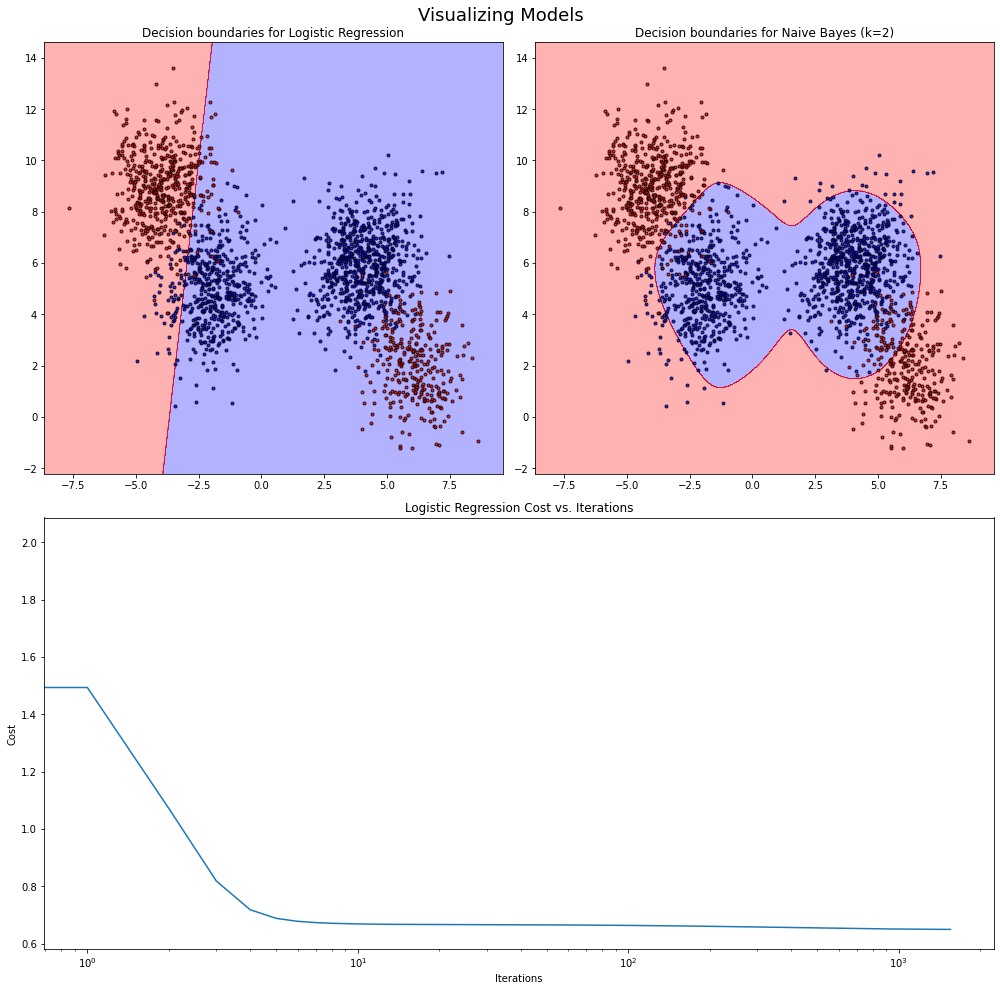

In [18]:
fig, axs = plt.subplots(ncols=2, nrows = 2, figsize=(14, 14)) 
fig.suptitle('Visualizing Models', fontsize=18)    

ax0 = axs[0,0]
ax1 = axs[0,1]

plot_decision_regions(x_train, y_train, lr, ax=ax0)
plot_decision_regions(x_train, y_train, nb2, ax=ax1)


gs = axs[1, 0].get_gridspec()
# remove the underlying axes
for ax in axs[1,:]:
    ax.remove()
axbig = fig.add_subplot(gs[1, :])


axbig.plot(lr.J_history)
axbig.set_xscale('log')
axbig.set_xlabel('Iterations')
axbig.set_ylabel('Cost')

ax0.set_title("Decision boundaries for Logistic Regression")
ax1.set_title('Decision boundaries for Naive Bayes (k=2)')
axbig.set_title("Logistic Regression Cost vs. Iterations")

# It is 2022 and matplotlib has a title bug? We fix it with tightlayout and some headspace definitions
fig.tight_layout()

plt.show();

As we are using the full data set, we know that the data is not easily separated by a line. We expect the linear regression to perform poorly if at all, and the naive bayes to perform better.

According to the graph above, we can observe that the logistic regression did not succeed to produce an accurate decision boundary (upper left hand side). Even though it was assumed that all the features are independent, we have better results with naive bayes, and we can observe more precise decision boundaries on the data. Naive bayes can have more complex decision boundaries. The naive assumption of independence holds and in such cases naive bayes classifiers can have more complex decision boundaries even if the classes are not linearly separable. Despite this, we have high accuracy since the classifier was correct on some of the classes, due to chance, despite the regression performing poorly. We see that naive bayes (upper right hand side) with EM performs better. 

At the bottom, we can observe a faster convergence than the data subset we worked with before.

## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
   1. Generate a dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Naive Bayes will work better than Logisitc Regression**.
   2. Generate another dataset, in 3 dimensions (3 features), with 2 classes, using **only** Multivariate-Gaussians (as many as you want) that you think **Logistic Regression will work better than Naive Bayes**.
   
   - Explain the reasoning behind each dataset.  

2. Visualize the datasets.  
   You can choose one of two options for the visualization:
    1. Plot three 2d graphs of all the features against each other (feature1 vs feature2, feature1 vs feature3, feature2 vs feature3).
    2. Plot one 3d graph.

**Important Note**  
For this question only, you may use:  
```
from scipy.stats import multivariate_normal
```

#### Your code and explanations here ####


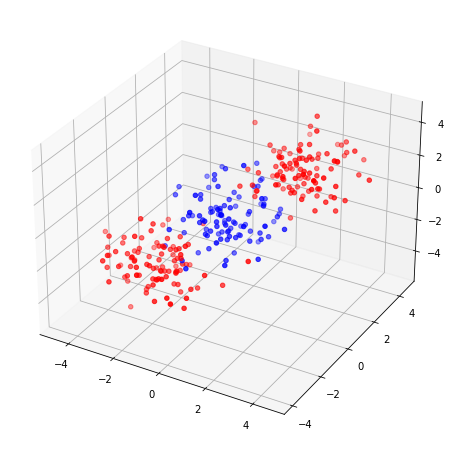

In [19]:
from scipy.stats import multivariate_normal

N=100
X = multivariate_normal.rvs(mean=[-2,-2,-2],cov=1, size=N)
X = np.r_[X, multivariate_normal.rvs(mean=[0,0,0],cov=1, size=N)]
X = np.r_[X, multivariate_normal.rvs(mean=[2,2,2],cov=1, size=N)]

cl = np.r_[ np.ones(N, dtype='int8'), 
            np.zeros(N, dtype='int8'),
            np.ones(N,dtype='int8')
          ] 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c = np.array(['blue','red'])[cl]);


Here, we generated a 3D dataset that consists of a Gaussian cloud of points in the center, with class value set to 0 (blue in the 3d scatterplot shown above), and two Gaussian clouds of points with class value set to 1 (red) located symmetrically on the either side of the blue (class=0) cloud. 

Clearly it is not possible in this case to draw a linear decision boundary (a 2D plane in the 3D space) that would provide any decent separation between blue and red points, hence logistic regression in the space of the three original predictor variables should perform poorly.

In fact, one can speculate that the best (linear) boundary logistic regression could possibly find is probably a plane that leaves one of the red clouds on one side (and classifies that half-space as 1), and the other red cloud *and* the blue one on the other side (and classifies that half-space as 0). In this case the predictions would be ~100% correct for the former cloud, also correct for ~100% of the points in the blue cloud, and ~0% correct for the points in the other red cloud (the one that ends up on the same side of the decision boundary as the blue points). Given that in our dataset we have the same number of points in each cloud, the overall accuracy can be thus expected to be around 2/3, i.e. 66%.

Naive bayes allows for non-linear boundary and it should perform better even at $k=1$, as it should be able to accurately fit the (single) gaussian cloud with the blue points and just contrasting it against a (single) Gaussian fit to "all the other" points might already provide a better model.

And at $k=2$ we should be already able to approximate the true underlying distributions of the red and blue points quite nicely.

Let us run a quick test (we do *not* optimize `acc` and `eps` for this dataset, and we look only at training accuracies here, so it is just a quick look and a sanity check):

In [20]:
lr_oq = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_oq.fit(X, cl)

nb_oq_1 = NaiveBayesGaussian(k=1)
nb_oq_1.fit(X, cl)

nb_oq_2 = NaiveBayesGaussian(k=2)
nb_oq_2.fit(X, cl)

nb_oq_3 = NaiveBayesGaussian(k=3)
nb_oq_3.fit(X, cl)

lr_oq_train_accuracy = compute_accuracy(lr_oq, X,cl)
nb_oq_1_train_accuracy = compute_accuracy(nb_oq_1, X,cl)
nb_oq_2_train_accuracy = compute_accuracy(nb_oq_2, X,cl)
nb_oq_3_train_accuracy = compute_accuracy(nb_oq_3, X,cl)

print(f'Logistic Regression: Train Accuracy = {lr_oq_train_accuracy:0.3f}')
print(f'Naive Bayes (k=1): Train Accuracy = {nb_oq_1_train_accuracy:0.3f}')
print(f'Naive Bayes (k=2): Train Accuracy = {nb_oq_2_train_accuracy:0.3f}')
print(f'Naive Bayes (k=3): Train Accuracy = {nb_oq_3_train_accuracy:0.3f}')


Logistic Regression: Train Accuracy = 0.667
Naive Bayes (k=1): Train Accuracy = 0.883
Naive Bayes (k=2): Train Accuracy = 0.920
Naive Bayes (k=3): Train Accuracy = 0.913


It looks like the behavior is what's expected here.

The reason that naive bayes performs better is because the clusters were generated independently at random. Thus preserving the naive assumption.

Let us now simulate a different dataset:

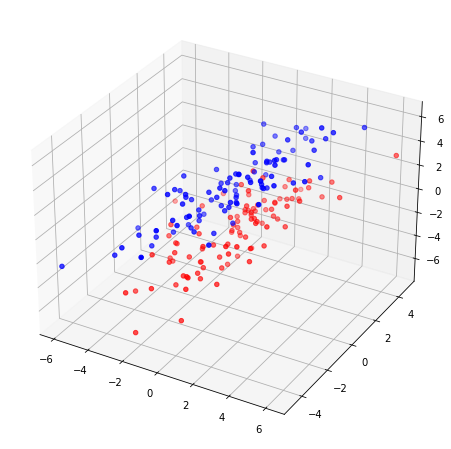

In [21]:
def generate_set2(size):
    X = multivariate_normal.rvs(mean=[0,0,-2],cov=[[2,3,3],[3,2,3],[3,3,2]], size=size)
    X = np.r_[X, multivariate_normal.rvs(mean=[0,0,2],cov=[[2,3,3],[3,2,3],[3,3,2]], size=size)]

    cl = np.r_[ np.ones(size, dtype='int8'), 
                np.zeros(size, dtype='int8'),
              ] 
    return X, cl

X, cl = generate_set2(N)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c = np.array(['blue','red'])[cl]);


Here, the linear boundary should be sufficient and in fact is the *correct* one, given that the two Gaussian clouds the points were sampled from have the same covariances.

One could expect that since NB allows for a nonlinear boundary as we have seen in the decision boundary plots generated above, it should be able to reproduce a linear boundary as a special case; the problem would be only with NB being more flexible than actually needed and thus overfitting any finite dataset. The much bigger issue, however, is the underlying assumption of NS, that of *conditional independence* of the features. 

In the dataset shown above, the decision boundary is linear, so both LR and NB should do fine on that front, but the features are strongly correlated. Let's see what we get for the training and test accuracies (since we know how the data were generated, we can just independently draw a new dataset using the same ditributions in order to obtain test data):


In [22]:
lr_oq_p2 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_oq_p2.fit(X, cl)

nb_oq_p2 = NaiveBayesGaussian(k=1)
nb_oq_p2.fit(X, cl)

Xtst, cl_tst = generate_set2(10000)

lr_oqp2_train_accuracy = compute_accuracy(lr_oq_p2, X,cl)
lr_oqp2_test_accuracy = compute_accuracy(lr_oq_p2, Xtst,cl_tst)
nb_oqp2_train_accuracy = compute_accuracy(nb_oq_p2, X,cl)
nb_oqp2_test_accuracy = compute_accuracy(nb_oq_p2, Xtst,cl_tst)

print(f'Logistic Regression: Train Accuracy = {lr_oqp2_train_accuracy}')
print(f'Logistic Regression: Test Accuracy = {lr_oqp2_test_accuracy}')
print(f'Naive Bayes (k=1): Train Accuracy = {nb_oqp2_train_accuracy}')
print(f'Naive Bayes (k=1): Test Accuracy = {nb_oqp2_test_accuracy}')

Logistic Regression: Train Accuracy = 0.95
Logistic Regression: Test Accuracy = 0.9488
Naive Bayes (k=1): Train Accuracy = 0.86
Naive Bayes (k=1): Test Accuracy = 0.8709


For a final test, we generate similarly a dataset and shift our data (it is dependent and there is a function from one to the other and check again)

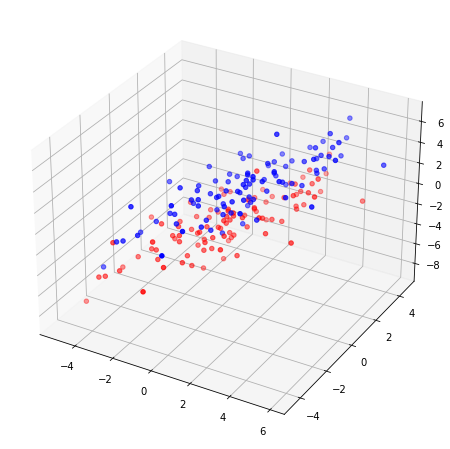

In [23]:
def generate_set3(size):
    X = multivariate_normal.rvs(mean=[0,0,-2],cov=[[2,3,3],[3,2,3],[3,3,2]], size=size)
    # create dependence and a linear relationship
    X = np.r_[X, X+np.array([1,0,4])]

    cl = np.r_[ np.ones(size, dtype='int8'), 
                np.zeros(size, dtype='int8'),
              ] 
    return X, cl

X, cl = generate_set3(N)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], c = np.array(['blue','red'])[cl]);

In [24]:
lr_oq_p3 = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_oq_p3.fit(X, cl)

nb_oq_p3 = NaiveBayesGaussian(k=1)
nb_oq_p3.fit(X, cl)

Xtst, cl_tst = generate_set3(10000)

lr_oqp3_train_accuracy = compute_accuracy(lr_oq_p3, X,cl)
lr_oqp3_test_accuracy = compute_accuracy(lr_oq_p3, Xtst,cl_tst)
nb_oqp3_train_accuracy = compute_accuracy(nb_oq_p3, X,cl)
nb_oqp3_test_accuracy = compute_accuracy(nb_oq_p3, Xtst,cl_tst)

print(f'Logistic Regression: Train Accuracy = {lr_oqp3_train_accuracy}')
print(f'Logistic Regression: Test Accuracy = {lr_oqp3_test_accuracy}')
print(f'Naive Bayes (k=1): Train Accuracy = {nb_oqp3_train_accuracy}')
print(f'Naive Bayes (k=1): Test Accuracy = {nb_oqp3_test_accuracy}')


Logistic Regression: Train Accuracy = 0.945
Logistic Regression: Test Accuracy = 0.94015
Naive Bayes (k=1): Train Accuracy = 0.87
Naive Bayes (k=1): Test Accuracy = 0.8404


Again we can observe that NB performs better than LR.